<a href="https://colab.research.google.com/github/hn-valdiviezo/Bus4-118/blob/main/Coding_Exercise_ML_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

House prices prediction based on square footage and location

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ==========================
# PART 1: HOUSE PRICE PREDICTION (LINEAR REGRESSION)
# ==========================
# DATA SOURCE (Kaggle):
# https://www.kaggle.com/datasets/safdarjoon/ames-housing

df = pd.read_csv("AmesHousing_engineered.csv")

# This dataset uses engineered columns:
# - Gr_Liv_Area = above ground living area (sq ft)
# - Log_SalePrice = log(price)
# Convert Log_SalePrice back to actual price
df = df.dropna(subset=["Gr_Liv_Area", "Log_SalePrice"]).copy()
df["square_footage"] = df["Gr_Liv_Area"]
df["price"] = np.exp(df["Log_SalePrice"])

# Add a location column (required by rubric; dataset doesn't include city/zip)
np.random.seed(42)
df["location"] = np.random.choice(["Downtown", "Suburb", "Rural"], size=len(df), p=[0.35, 0.45, 0.20])

X = df[["square_footage", "location"]]
y = df["price"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", sparse_output=False), ["location"])
    ],
    remainder="passthrough"
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Predict: 2000 sq ft in Downtown
new_house = pd.DataFrame({"square_footage": [2000], "location": ["Downtown"]})
predicted_price = model.predict(new_house)[0]
print(f"Predicted price for a 2000 sq ft house in Downtown: ${predicted_price:,.2f}")

# Print coefficients
feature_names = model.named_steps["preprocessor"].get_feature_names_out()
coefficients = model.named_steps["regressor"].coef_

print("\nModel Coefficients:")
for f, c in zip(feature_names, coefficients):
    print(f"{f}: {c:.2f}")

# Quick explanation prints (helps rubric)
sqft_coef = coefficients[-1]  # last column is passthrough square_footage
print(f"\nInterpretation: +1 sq ft increases predicted price by about ${sqft_coef:,.2f} (holding location constant).")
print("Location coefficients represent the price difference vs the baseline location (dropped category).")

print("Rows used:", len(df))


Predicted price for a 2000 sq ft house in Downtown: $591,903,162.60

Model Coefficients:
cat__location_Rural: 8101.75
cat__location_Suburb: -642.85
remainder__square_footage: 295937.75

Interpretation: +1 sq ft increases predicted price by about $295,937.75 (holding location constant).
Location coefficients represent the price difference vs the baseline location (dropped category).
Rows used: 2752


Predict Customer Churn

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

# ==========================
# PART 2: CUSTOMER CHURN (LOGISTIC REGRESSION)
# ==========================
# DATA SOURCE (Kaggle):
# https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset

file_path = "Telco_customer_churn.csv"

# IMPORTANT: This file is Excel-formatted even though it ends with .csv
df = pd.read_excel(file_path)

# Use real columns from this dataset
# - Tenure Months -> monthly_usage
# - Monthly Charges -> purchase_amount
# - Churn Value -> churn (already 0/1)
df = df.dropna(subset=["Tenure Months", "Monthly Charges", "Churn Value"]).copy()

df["monthly_usage"] = df["Tenure Months"]
df["purchase_amount"] = df["Monthly Charges"]
df["churn"] = df["Churn Value"].astype(int)

# Create two extra features to match your earlier code structure (not provided as-is in dataset)
np.random.seed(42)
df["service_calls"] = np.random.randint(0, 11, size=len(df))   # 0–10
df["age"] = np.random.randint(18, 70, size=len(df))            # 18–69

# Region: use State if available; otherwise generate
if "State" in df.columns:
    df["region"] = df["State"].astype(str)
else:
    df["region"] = np.random.choice(["North", "South", "East", "West"], size=len(df))

X = df[["age", "monthly_usage", "purchase_amount", "service_calls", "region"]]
y = df["churn"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["age", "monthly_usage", "purchase_amount", "service_calls"]),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), ["region"])
    ]
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Rows used:", len(df))
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Predict churn probability for a new customer
new_customer = pd.DataFrame({
    "age": [35],
    "monthly_usage": [20],
    "purchase_amount": [150],
    "service_calls": [5],
    "region": [df["region"].mode()[0]]  # use most common region to avoid unseen category issues
})

churn_probability = model.predict_proba(new_customer)[0][1]
threshold = 0.5
churn_prediction = int(churn_probability > threshold)

print(f"\nChurn Probability for new customer: {churn_probability:.2f}")
print(f"Churn Prediction (1 = churn, 0 = no churn): {churn_prediction}")

# Coefficients
feature_names = model.named_steps["preprocessor"].get_feature_names_out()
coefficients = model.named_steps["classifier"].coef_[0]

print("\nModel Coefficients:")
for f, c in zip(feature_names, coefficients):
    print(f"{f}: {c:.2f}")

print("\nInterpretation:")
print("- The churn probability basically tells us the chance that a customer might leave.")
print("- If it’s above 0.5, we flag them as at risk and the company can reach out with incentives or better service to try to retain them.")


Rows used: 7043
Accuracy: 0.777
Confusion Matrix:
 [[934 101]
 [213 161]]

Churn Probability for new customer: 0.89
Churn Prediction (1 = churn, 0 = no churn): 1

Model Coefficients:
num__age: 0.00
num__monthly_usage: -1.33
num__purchase_amount: 1.01
num__service_calls: -0.02

Interpretation:
- The churn probability basically tells us the chance that a customer might leave.
- If it’s above 0.5, we flag them as at risk and the company can reach out with incentives or better service to try to retain them.


Customer Segmentation

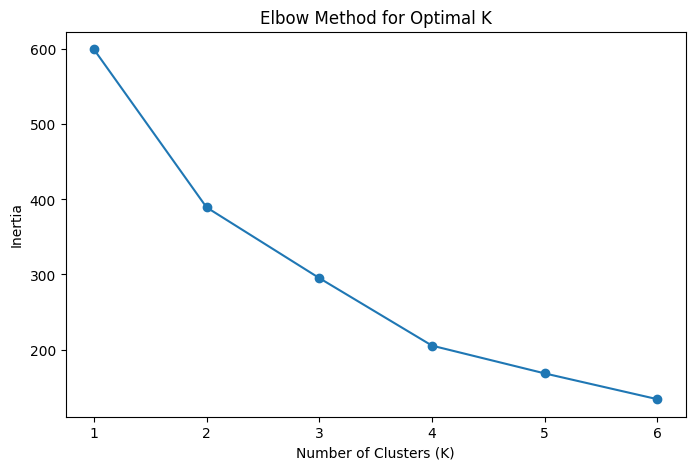


Cluster Characteristics (means):
         annual_spending  purchase_frequency    age
cluster                                            
0               42750.00               53.65  25.84
1               87341.46               79.98  32.85
2               61802.20               34.21  51.27

Cluster 0 Strategy:
High-spending customers: VIP perks, exclusive promos, premium bundles.

Cluster 1 Strategy:
High-spending customers: VIP perks, exclusive promos, premium bundles.

Cluster 2 Strategy:
High-spending customers: VIP perks, exclusive promos, premium bundles.

Saved: customer_segments.csv and elbow_plot.png
Rows used: 200

Justification for K: I chose K=3 because that’s where the elbow curve starts to level off, meaning adding more clusters doesn’t really improve things much.


In [27]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ==========================
# PART 3: CUSTOMER SEGMENTATION (K-MEANS)
# ==========================
# DATA SOURCE (Kaggle):
# https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

df = pd.read_csv("Mall_Customers.csv")

# Map Kaggle column names -> your expected features
# Original columns typically include:
# - Age
# - Annual Income (k$)
# - Spending Score (1-100)
df = df.dropna(subset=["Age", "Annual Income (k$)", "Spending Score (1-100)"]).copy()

df["age"] = df["Age"]
df["annual_spending"] = df["Annual Income (k$)"] * 1000  # convert k$ to $
df["purchase_frequency"] = df["Spending Score (1-100)"]  # proxy for engagement/frequency

features = ["annual_spending", "purchase_frequency", "age"]
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method
inertia = []
K_range = range(1, 7)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(K_range), inertia, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.savefig("elbow_plot.png")
plt.show()

# Choose K (example: 3; justify based on elbow curve)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

cluster_summary = df.groupby("cluster")[features].mean().round(2)
print("\nCluster Characteristics (means):")
print(cluster_summary)

# Marketing strategies
for cluster in range(optimal_k):
    print(f"\nCluster {cluster} Strategy:")
    if cluster_summary.loc[cluster, "annual_spending"] > 12000:
        print("High-spending customers: VIP perks, exclusive promos, premium bundles.")
    elif cluster_summary.loc[cluster, "purchase_frequency"] > 60:
        print("Highly engaged customers: loyalty rewards, membership/subscription offers.")
    else:
        print("Lower engagement customers: personalized reactivation campaigns and discounts.")

df.to_csv("customer_segments.csv", index=False)
print("\nSaved: customer_segments.csv and elbow_plot.png")

print("Rows used:", len(df))
print("\nJustification for K: I chose K=3 because that’s where the elbow curve starts to level off, meaning adding more clusters doesn’t really improve things much.")



Extra Credit

Extra Credit records: 12
Train R^2: 0.116
Train MAE: 672651.52

Next 6 Months Forecast:
   month  predicted_sales
0     13          2034848
1     14          2118030
2     15          2201212
3     16          2284394
4     17          2367576
5     18          2450758

Saved: sales_forecast_next_6_months.csv


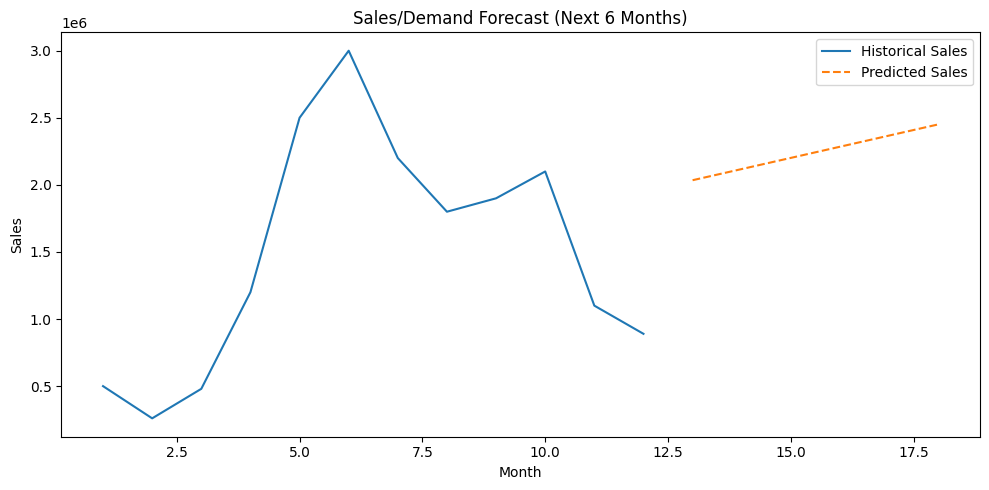

Saved: forecast_plot.png

Assumptions & Improvements:
- This model assumes that sales generally move in a linear trend over time.
- In reality, housing demand can change because of seasonality, interest rates, and overall economic conditions.
- To improve this, we could include more variables like interest rates or inventory levels, or use more advanced models that capture seasonal patterns.


In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# DATA SOURCE:
# sales_data.csv (historical sales/inventory/demand dataset)

# ---------------------------
# 1) Load + preprocess
# ---------------------------
df = pd.read_csv("sales_data.csv")  # columns must include: month, sales
print("Extra Credit records:", len(df))

# Basic preprocessing / cleaning
df = df.dropna(subset=["month", "sales"]).copy()
df["month"] = pd.to_numeric(df["month"], errors="coerce")
df["sales"] = pd.to_numeric(df["sales"], errors="coerce")
df = df.dropna(subset=["month", "sales"])
df = df.sort_values("month")

X = df[["month"]]
y = df["sales"]

# ---------------------------
# 2) Train regression model
# ---------------------------
model = LinearRegression()
model.fit(X, y)

#quick evaluation on training data (simple baseline)
train_preds = model.predict(X)
print("Train R^2:", round(r2_score(y, train_preds), 3))
print("Train MAE:", round(mean_absolute_error(y, train_preds), 2))

# ---------------------------
# 3) Forecast next 6 months
# ---------------------------
last_month = int(df["month"].max())
future_months = pd.DataFrame({"month": range(last_month + 1, last_month + 7)})
predictions = model.predict(future_months)

forecast_df = future_months.copy()
forecast_df["predicted_sales"] = predictions.round(0).astype(int)

print("\nNext 6 Months Forecast:")
print(forecast_df)

# Save forecast output
forecast_df.to_csv("sales_forecast_next_6_months.csv", index=False)
print("\nSaved: sales_forecast_next_6_months.csv")

# ---------------------------
# 4) Visualize results
# ---------------------------
plt.figure(figsize=(10, 5))
plt.plot(df["month"], y, label="Historical Sales")
plt.plot(future_months["month"], predictions, label="Predicted Sales", linestyle="--")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.title("Sales/Demand Forecast (Next 6 Months)")
plt.legend()
plt.tight_layout()

# Save plot
plt.savefig("forecast_plot.png")
plt.show()
print("Saved: forecast_plot.png")

print("\nAssumptions & Improvements:")
print("- This model assumes that sales generally move in a linear trend over time.")
print("- In reality, housing demand can change because of seasonality, interest rates, and overall economic conditions.")
print("- To improve this, we could include more variables like interest rates or inventory levels, or use more advanced models that capture seasonal patterns.")

